In [1]:
import random
import datasets
from src import data_loading
from src.data_models.data_models import TrainingData

dataset = datasets.load_dataset("lmarena-ai/arena-human-preference-140k")
data = data_loading.load_training_data_lmarena(dataset["train"].to_pandas())
#dataset = datasets.load_dataset("lmsys/chatbot_arena_conversations")
#data = data_loading.load_training_data_chatbot_arena(dataset["train"].to_pandas())
#data = TrainingData(random.sample(data.entries, 10000))
print(f"Successfully loaded {len(data.entries)} entries")

Successfully loaded 135634 entries


In [3]:
from src.models.embedding_specs.attention_embedding_spec import AttentionEmbeddingSpec
from src.models.length_prediction.gb_length_prediction_model import GbLengthPredictionModel
from src.models.optimizers.adamw_spec import AdamWSpec
from src.utils.data_split import ValidationSplit


name = "gb-length-prediction-model-first-test"
length_prediction_model = GbLengthPredictionModel(
    run_name=name,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    input_features=["prompt_embedding", "prompt_features", "model_embedding"],
    embedding_model_name="all-MiniLM-L6-v2",
    load_embedding_model_from="gradient_boosting/gradient-boosting-model-embeddings-only",
    min_model_comparisons=1000,
    seed=42,
    print_every=1,
)

length_prediction_model.train(data, validation_split=ValidationSplit(val_fraction=0.2, seed=42), epochs=1000)
length_prediction_model.save(name)

Round    1: rmse = 0.9620/1.0482, accuracy = 2.02%/1.92%, rel_err = 563.09%/570.15%, mae = 351.8/353.2 - 0.55s
Round    2: rmse = 0.9444/1.0325, accuracy = 2.33%/2.22%, rel_err = 542.51%/549.54%, mae = 341.4/343.1 - 0.09s
Round    3: rmse = 0.9267/1.0172, accuracy = 2.64%/2.52%, rel_err = 524.17%/531.05%, mae = 332.6/334.5 - 0.09s
Round    4: rmse = 0.9125/1.0058, accuracy = 2.97%/2.84%, rel_err = 507.35%/513.91%, mae = 324.9/327.0 - 0.09s
Round    5: rmse = 0.9006/0.9963, accuracy = 3.24%/3.09%, rel_err = 494.61%/501.56%, mae = 318.7/320.9 - 0.08s
Round    6: rmse = 0.8898/0.9875, accuracy = 3.56%/3.39%, rel_err = 481.17%/488.09%, mae = 313.0/315.4 - 0.08s
Round    7: rmse = 0.8812/0.9800, accuracy = 3.84%/3.67%, rel_err = 470.25%/476.71%, mae = 307.9/310.3 - 0.09s
Round    8: rmse = 0.8729/0.9718, accuracy = 4.14%/3.96%, rel_err = 459.37%/465.72%, mae = 303.2/305.8 - 0.08s
Round    9: rmse = 0.8659/0.9666, accuracy = 4.39%/4.20%, rel_err = 450.84%/457.28%, mae = 299.2/301.9 - 0.08s
R

In [ ]:
from src.models.embedding_specs.attention_embedding_spec import AttentionEmbeddingSpec
from src.models.length_prediction.dn_embedding_length_prediction_model import DnEmbeddingLengthPredictionModel
from src.models.optimizers.adamw_spec import AdamWSpec
from src.utils.data_split import ValidationSplit


name = "dn-embedding-length-prediction-model-first-test"
length_prediction_model = DnEmbeddingLengthPredictionModel(
    run_name=name,
    embedding_model_name="all-MiniLM-L6-v2",
    hidden_dims=[256, 256, 128, 64],
    optimizer_spec=AdamWSpec(
        learning_rate=5e-4,
        lr_decay_gamma=0.99,
    ),
    load_embedding_model_from="gradient_boosting/gradient-boosting-model-embeddings-only",
    min_model_comparisons=1000,
    seed=42,
    print_every=1,
)

length_prediction_model.train(data, validation_split=ValidationSplit(val_fraction=0.2, seed=42), epochs=100, batch_size=512)
length_prediction_model.save(name)

In [ ]:
from src.models.optimizers.adamw_spec import AdamWSpec
from src.models.response_predictive_model import ResponsePredictiveModel
from src.utils.data_split import ValidationSplit


name = "response-predictive-model-first-test"
response_predictive_model = ResponsePredictiveModel(
    embedding_model_name="all-MiniLM-L6-v2",
    response_repr_dim=128,
    encoder_hidden_dims=[512, 512,256, 256, 128, 128],
    predictor_hidden_dims=[256, 256, 128, 128],
    scorer_hidden_dims=[512, 512, 512, 512, 256, 256, 128, 128],
    prediction_loss_weight=0.01,
    dropout=0.4,
    real_repr_ratio=1,
    real_repr_decay_per_epoch=1/50,
    optimizer_spec=AdamWSpec(
        learning_rate=5e-5,
        lr_decay_gamma=0.995,
        weight_decay=0.01,
    ),
    load_embedding_model_from="gradient_boosting/gradient-boosting-model-embeddings-only",
    balance_model_samples=True,
    min_model_comparisons=1000,
    checkpoint_name=name,
    save_every=4,
    print_every=1,
    seed=42,
)

response_predictive_model.train(data, validation_split=ValidationSplit(val_fraction=0.2, seed=42), epochs=150, batch_size=256)
response_predictive_model.save(name)

In [ ]:
import matplotlib.pyplot as plt
from src.plotting_utils import plot_loss, plot_accuracy

prompt_invariant_model = GradientBoostingModel.load("gradient-boosting-model-embeddings-only")

prompt_invariant_history = prompt_invariant_model.get_history()
_, axes = plt.subplots(2, 2, figsize=(15, 10))

plot_loss(axes[0, 0], prompt_invariant_history.total_loss, "Training loss")
plot_loss(axes[0, 1], prompt_invariant_history.val_loss, "Validation loss")
plot_accuracy(axes[1, 0], prompt_invariant_history.train_accuracy, "Training accuracy")
plot_accuracy(axes[1, 1], prompt_invariant_history.val_accuracy, "Validation accuracy")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from src.plotting_utils import plot_loss, plot_accuracy

embedding_history = prompt_invariant_model.embedding_model._epoch_logs

_, axes = plt.subplots(3, 2, figsize=(15, 15))

plot_loss(axes[0, 0], [e.train_loss for e in embedding_history], "Training loss")
plot_loss(axes[0, 1], [e.val_loss for e in embedding_history], "Validation loss")
plot_accuracy(axes[1, 0], [e.triplet_accuracy for e in embedding_history], "Training triplet accuracy")
plot_accuracy(axes[1, 1], [e.val_triplet_accuracy for e in embedding_history], "Validation triplet accuracy")
# plot_accuracy(axes[2, 0], [e.nearest_neighbor_accuracy for e in embedding_history], "Training nearest neighbor accuracy")
# plot_accuracy(axes[2, 1], [e.val_nearest_neighbor_accuracy for e in embedding_history], "Validation nearest neighbor accuracy")
plot_accuracy(axes[2, 0], [e.train_universal_accuracy for e in embedding_history], "Training universal accuracy")
plot_accuracy(axes[2, 1], [e.val_universal_accuracy for e in embedding_history], "Validation universal accuracy")

# axes[2, 0].plot([e.train_loss for e in embedding_history], label="Training loss")
# axes[2, 0].plot([e.train_triplet_loss for e in embedding_history], label="Training triplet loss")
# axes[2, 0].plot([e.train_reg_loss for e in embedding_history], label="Training regularization loss")
# axes[2, 0].legend()

In [ ]:
metrics = set(length_prediction_model.get_history().additional_metrics.keys())
for metric in metrics:
    print(metric)

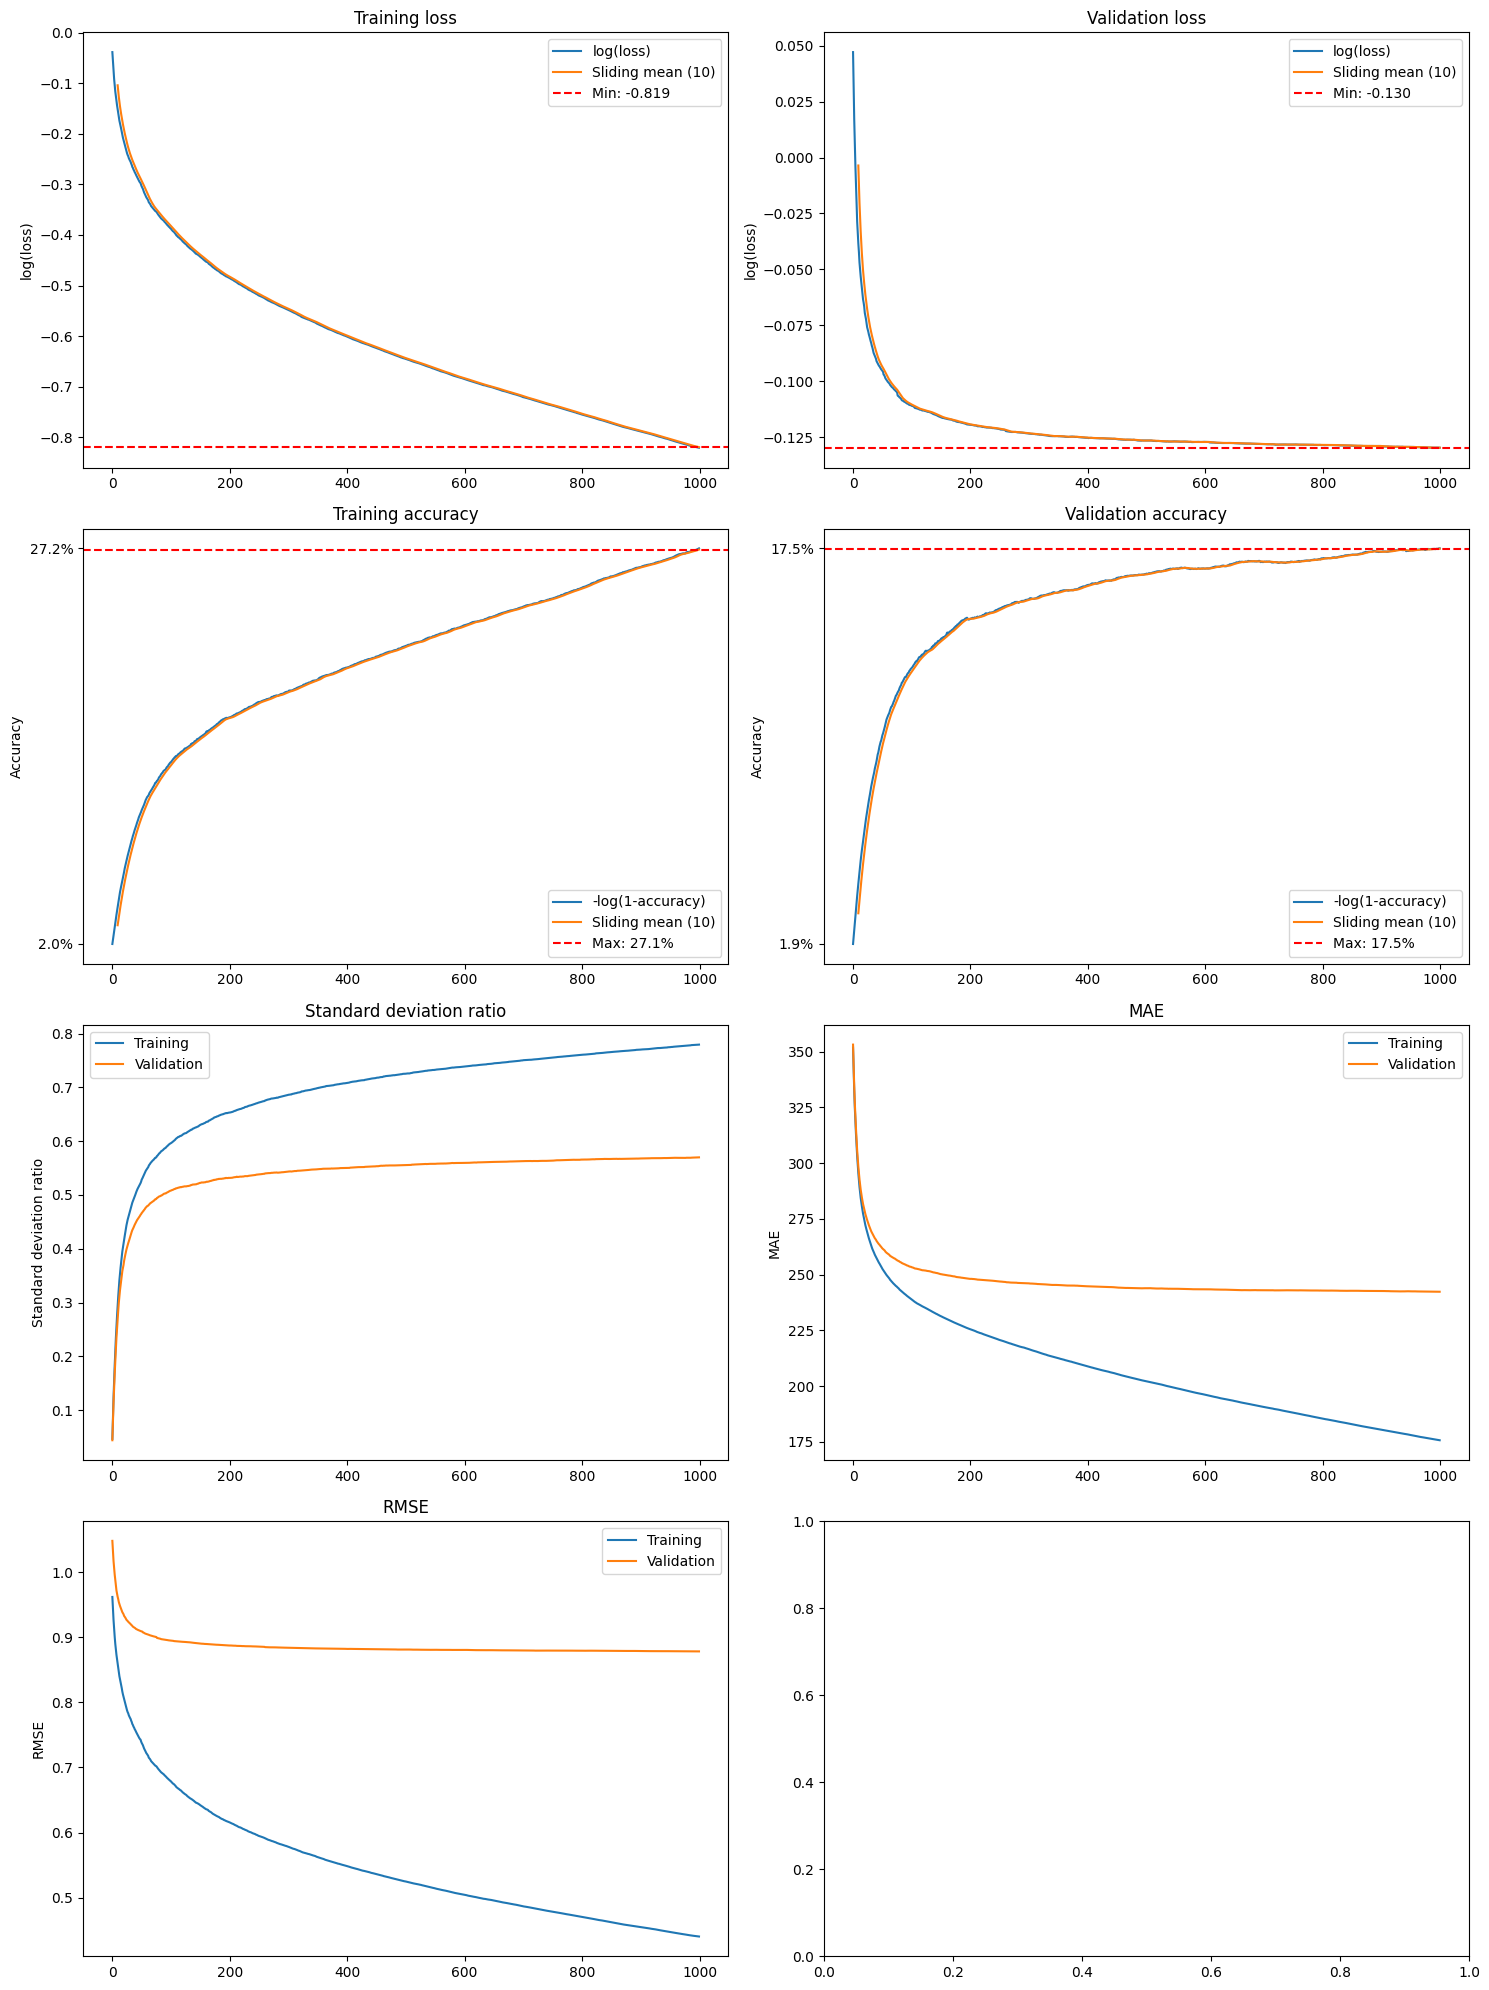

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotting_utils import plot_loss, plot_accuracy

length_prediction_history = length_prediction_model.get_history()
_, axes = plt.subplots(4, 2, figsize=(15, 20))

plot_loss(axes[0, 0], length_prediction_history.total_loss, "Training loss")
plot_loss(axes[0, 1], length_prediction_history.val_loss, "Validation loss")
plot_accuracy(axes[1, 0], length_prediction_history.train_accuracy, "Training accuracy")
plot_accuracy(axes[1, 1], length_prediction_history.val_accuracy, "Validation accuracy")

axes[2, 0].plot(length_prediction_history.additional_metrics["train_stddev_ratio"], label="Training")
axes[2, 0].plot(length_prediction_history.additional_metrics["val_stddev_ratio"], label="Validation")
axes[2, 0].set_ylabel("Standard deviation ratio")
axes[2, 0].set_title("Standard deviation ratio")
axes[2, 0].legend()

axes[2, 1].plot(length_prediction_history.additional_metrics["train_mae"], label="Training")
axes[2, 1].plot(length_prediction_history.additional_metrics["val_mae"], label="Validation")
axes[2, 1].set_ylabel("MAE")
axes[2, 1].set_title("MAE")
axes[2, 1].legend()

axes[3, 0].plot(length_prediction_history.additional_metrics["train_rmse"], label="Training")
axes[3, 0].plot(length_prediction_history.additional_metrics["val_rmse"], label="Validation")
axes[3, 0].set_ylabel("RMSE")
axes[3, 0].set_title("RMSE")
axes[3, 0].legend()

# plot_accuracy(axes[2, 0], response_predictive_history.additional_metrics["scorer_real_repr_accuracy"], "Scorer real representation accuracy (training)")
# plot_accuracy(axes[2, 1], response_predictive_history.additional_metrics["val_scorer_real_repr_accuracy"], "Scorer real representation accuracy (validation)")

# plot_accuracy(axes[3, 0], response_predictive_history.additional_metrics["prediction_quality"], "Prediction quality (training)")
# plot_accuracy(axes[3, 1], response_predictive_history.additional_metrics["val_prediction_quality"], "Prediction quality (validation)")

# train_variance = response_predictive_history.additional_metrics["repr_mean_variance"]
# val_variance = response_predictive_history.additional_metrics["val_repr_mean_variance"]
# axes[4, 0].plot(np.log(train_variance), label="Training variance")
# axes[4, 0].plot(np.log(val_variance), label="Validation variance")
# axes[4, 0].set_xlabel("Epoch")
# axes[4, 0].set_ylabel("log(variance)")
# axes[4, 0].set_title("Variance of response representations")
# axes[4, 0].legend()

# plot_loss(axes[4, 1], response_predictive_history.additional_metrics["prediction_loss"], "Prediction loss (training)")

plt.tight_layout()
plt.show()